In [35]:
from ucimlrepo import fetch_ucirepo 
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import adjusted_rand_score, v_measure_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score 

## Loading and exploring data

In [36]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 

x = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

In [37]:
(breast_cancer_wisconsin_diagnostic.metadata) 

{'uci_id': 17,
 'name': 'Breast Cancer Wisconsin (Diagnostic)',
 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic',
 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv',
 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.',
 'area': 'Health and Medicine',
 'tasks': ['Classification'],
 'characteristics': ['Multivariate'],
 'num_instances': 569,
 'num_features': 30,
 'feature_types': ['Real'],
 'demographics': [],
 'target_col': ['Diagnosis'],
 'index_col': ['ID'],
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 1993,
 'last_updated': 'Fri Nov 03 2023',
 'dataset_doi': '10.24432/C5DW2B',
 'creators': ['William Wolberg',
  'Olvi Mangasarian',
  'Nick Street',
  'W. Street'],
 'intro_paper': {'ID': 230,
  'type': 'NATIVE',
  'title': 'Nuclear feature extraction for breast tumor diagnosis',
  'authors': 'W. Street, W. Wolberg, O. Mangasarian',
  'venue': 'Electronic imaging',
  'yea

In [38]:
print(breast_cancer_wisconsin_diagnostic.variables) 


                  name     role         type demographic description units  \
0                   ID       ID  Categorical        None        None  None   
1            Diagnosis   Target  Categorical        None        None  None   
2              radius1  Feature   Continuous        None        None  None   
3             texture1  Feature   Continuous        None        None  None   
4           perimeter1  Feature   Continuous        None        None  None   
5                area1  Feature   Continuous        None        None  None   
6          smoothness1  Feature   Continuous        None        None  None   
7         compactness1  Feature   Continuous        None        None  None   
8           concavity1  Feature   Continuous        None        None  None   
9      concave_points1  Feature   Continuous        None        None  None   
10           symmetry1  Feature   Continuous        None        None  None   
11  fractal_dimension1  Feature   Continuous        None        

In [39]:
x.shape

(569, 30)

In [40]:
y.value_counts()

Diagnosis
B            357
M            212
Name: count, dtype: int64

## Scaling

In [41]:
lblenc =LabelEncoder()
y = lblenc.fit_transform(y.values.reshape(-1,))

In [42]:
stdscaler = StandardScaler()
x_std = stdscaler.fit_transform(x)

minmax = MinMaxScaler()
x_minmax = minmax.fit_transform(x)

## PCA

In [43]:
pca = PCA(n_components=3,whiten=True)
x_std_pca = pca.fit_transform(x_std)

In [44]:
# Verify the # of n_components using the explained_varience_ratio_ (> 0.7)
np.cumsum(pca.explained_variance_ratio_)

array([0.44272026, 0.63243208, 0.72636371])

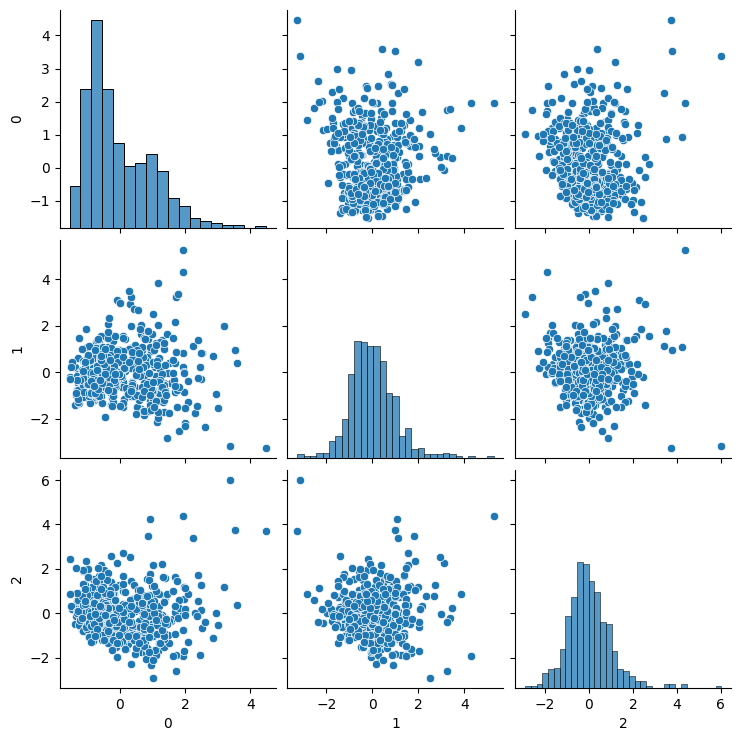

In [45]:
sns.pairplot(pd.DataFrame(x_std_pca))

In [46]:
pca = PCA(n_components=2,whiten=True)
x_minmax_pca = pca.fit_transform(x_minmax)

In [47]:
pca.components_.T

array([[ 2.42675774e-01, -2.61316697e-01],
       [ 9.64786101e-02, -5.90579194e-02],
       [ 2.52550175e-01, -2.38590061e-01],
       [ 2.16494530e-01, -2.31106830e-01],
       [ 1.09694618e-01,  1.99883951e-01],
       [ 2.40397602e-01,  2.13914883e-01],
       [ 3.01914206e-01,  1.13810591e-01],
       [ 3.22475470e-01, -8.31206237e-03],
       [ 1.11431911e-01,  2.11115126e-01],
       [ 4.32983397e-02,  4.06392087e-01],
       [ 1.21760615e-01, -6.68985209e-02],
       [-3.91796003e-05,  6.00114468e-02],
       [ 1.18580603e-01, -5.14164640e-02],
       [ 1.03569266e-01, -8.29631528e-02],
       [-4.68418094e-03,  1.35596439e-01],
       [ 1.29319789e-01,  2.22352585e-01],
       [ 6.56807080e-02,  1.02792720e-01],
       [ 1.24746120e-01,  1.05646780e-01],
       [ 1.44902467e-02,  1.40474907e-01],
       [ 4.55013416e-02,  1.71995173e-01],
       [ 2.59386850e-01, -2.44281614e-01],
       [ 1.13833007e-01, -3.96817047e-02],
       [ 2.60708399e-01, -2.11635403e-01],
       [ 2.

In [48]:
loading_df = pd.DataFrame(pca.components_.T, index = x.columns, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])

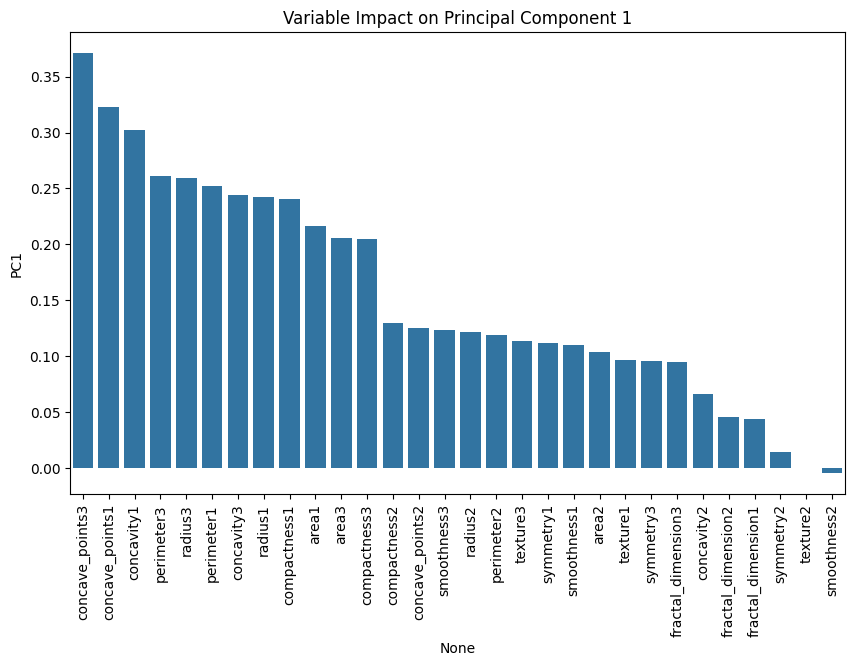

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(x=loading_df['PC1'].sort_values(ascending=False).index, 
            y=loading_df['PC1'].sort_values(ascending=False))
plt.title('Variable Impact on Principal Component 1')
plt.xticks(rotation=90)
plt.show()


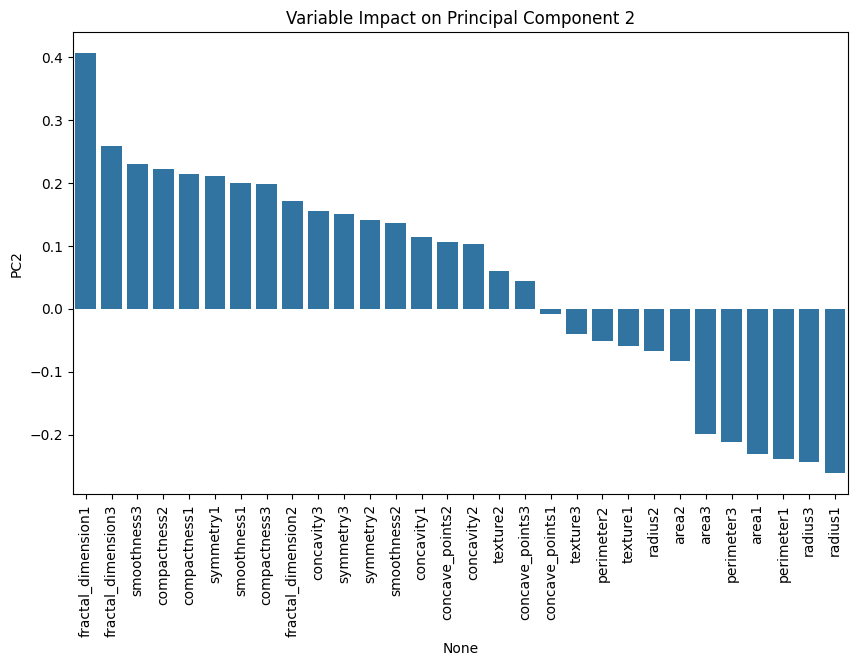

In [50]:
plt.figure(figsize=(10, 6))
sns.barplot(x=loading_df['PC2'].sort_values(ascending=False).index, 
            y=loading_df['PC2'].sort_values(ascending=False))
plt.title('Variable Impact on Principal Component 2')
plt.xticks(rotation=90)
plt.show()


In [51]:
# Verify the # of n_components using the explained_varience_ratio_ (> 0.7)
np.cumsum(pca.explained_variance_ratio_)

array([0.53097689, 0.70381179])

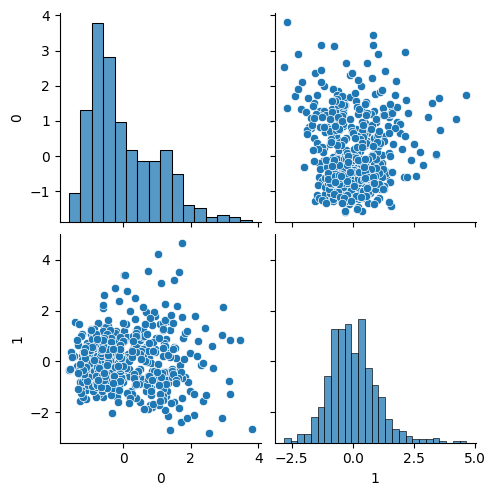

In [52]:
sns.pairplot(pd.DataFrame(x_minmax_pca))

## Clustering

### Functions

In [53]:
metrics = []
def save_metrics(model,x,y,pred):
    silhouette = silhouette_score(x,pred)
    davies_bouldin = davies_bouldin_score(x,pred)
    adjusted_rand = adjusted_rand_score(y,pred)
    v_measure = v_measure_score(y,pred)
    calinski = calinski_harabasz_score(x,pred)
    
    metrics.append([model,silhouette,davies_bouldin,adjusted_rand,v_measure,calinski])

In [54]:
def elbow_method(X):
    inertia = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    plt.plot(range(1, 11), inertia, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('# of Clusters')
    plt.ylabel('inertia')
    plt.show()

### K-Means

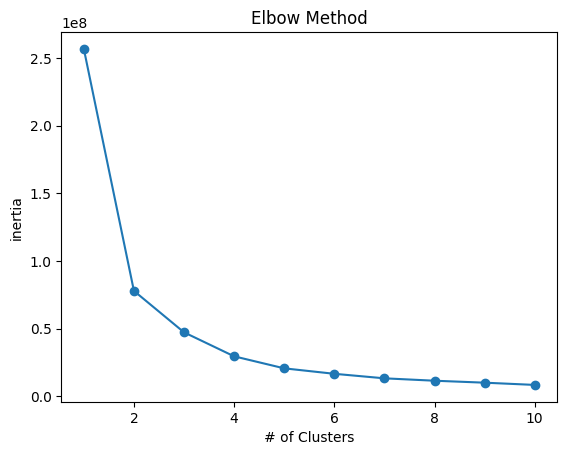

In [55]:
elbow_method(x)

In [56]:
kmeans_std = KMeans(n_clusters=2)
pred_std_kmeans = kmeans_std.fit_predict(x_std_pca)
save_metrics('kmeans - stdScaler',x_std_pca,y,pred_std_kmeans)

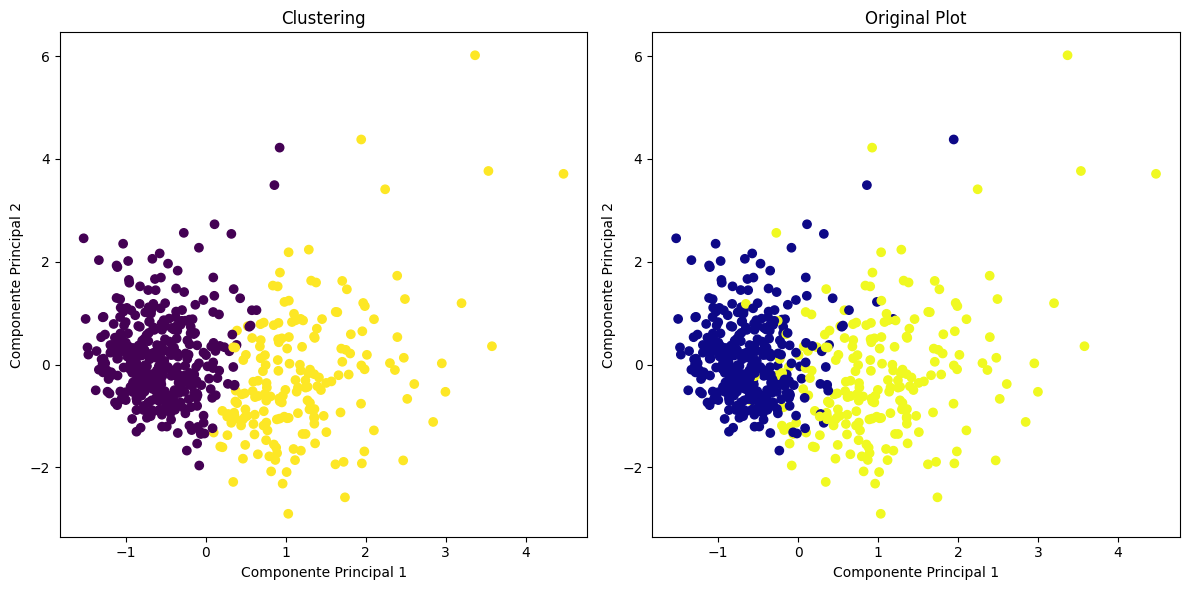

In [57]:
# Crear un objeto de figura
plt.figure(figsize=(12, 6))

# Primer subplot para el clustering
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subplot
plt.scatter(x_std_pca[:, 0], x_std_pca[:, 2], c=pred_std_kmeans, label='Clustering', cmap='viridis')
plt.title('Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Segundo subplot para el gráfico original
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo subplot
plt.scatter(x_std_pca[:, 0], x_std_pca[:, 2], c=y, label='Original Plot', cmap='plasma')
plt.title('Original Plot')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

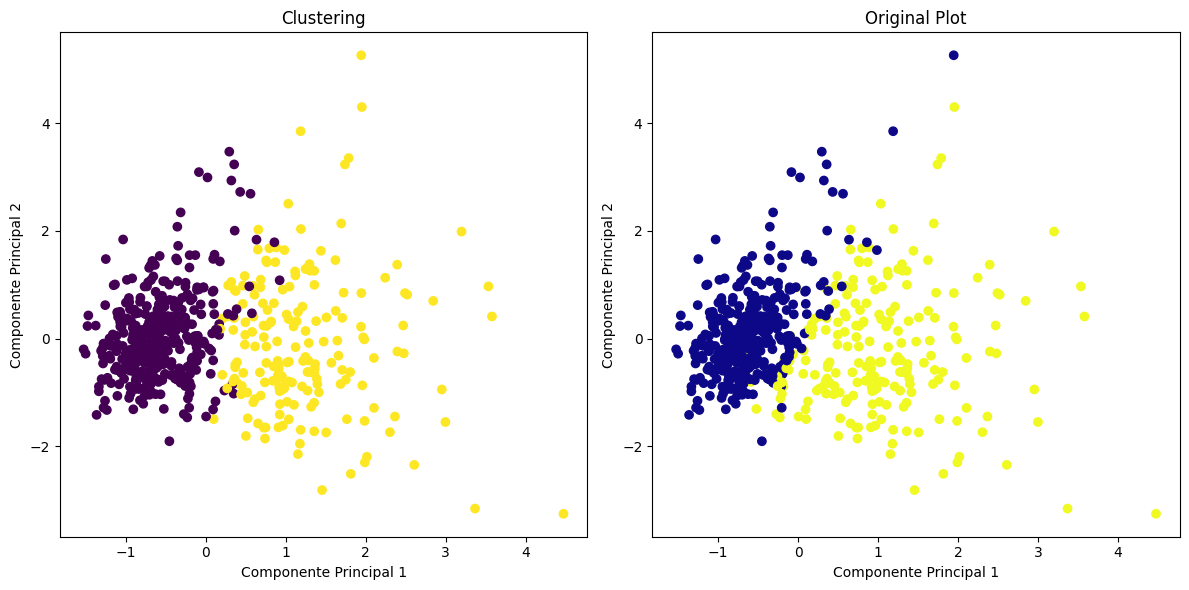

In [58]:
# Crear un objeto de figura
plt.figure(figsize=(12, 6))

# Primer subplot para el clustering
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subplot
plt.scatter(x_std_pca[:, 0], x_std_pca[:, 1], c=pred_std_kmeans, label='Clustering', cmap='viridis')
plt.title('Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Segundo subplot para el gráfico original
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo subplot
plt.scatter(x_std_pca[:, 0], x_std_pca[:, 1], c=y, label='Original Plot', cmap='plasma')
plt.title('Original Plot')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [59]:
kmeans_minmax = KMeans(n_clusters=2)
pred_minmax_kmeans = kmeans_std.fit_predict(x_minmax_pca)
save_metrics('kmeans - minmaxScaler',x_minmax_pca,y,pred_minmax_kmeans)

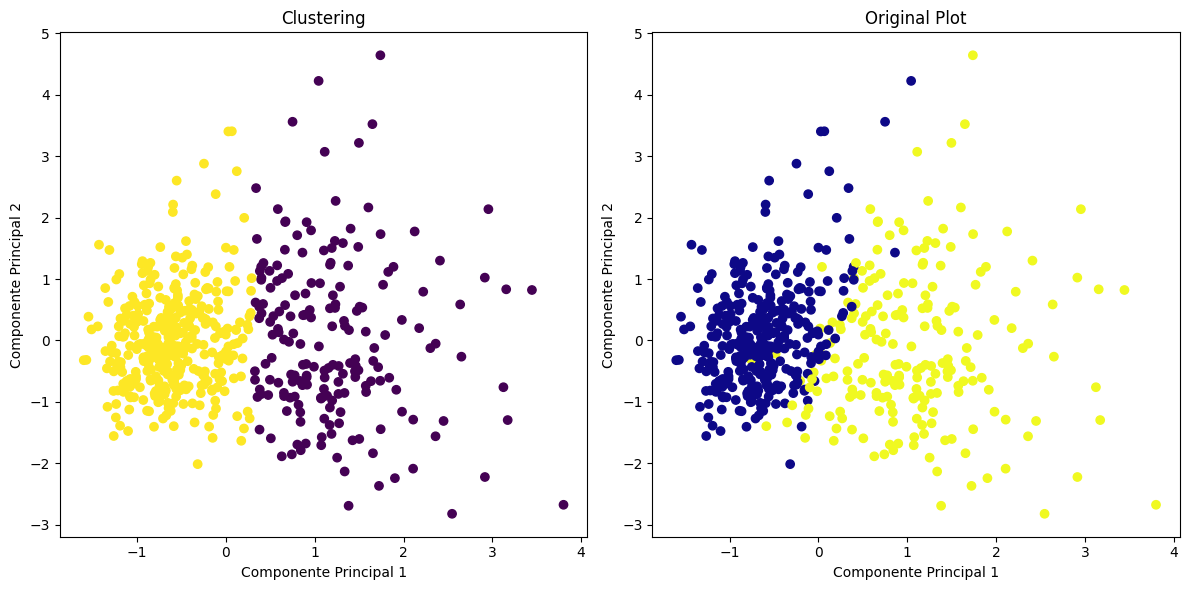

In [60]:
# Crear un objeto de figura
plt.figure(figsize=(12, 6))

# Primer subplot para el clustering
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subplot
plt.scatter(x_minmax_pca[:, 0], x_minmax_pca[:, 1], c=pred_minmax_kmeans, label='Clustering', cmap='viridis')
plt.title('Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Segundo subplot para el gráfico original
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo subplot
plt.scatter(x_minmax_pca[:, 0], x_minmax_pca[:, 1], c=y, label='Original Plot', cmap='plasma')
plt.title('Original Plot')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

### DBSCAN

In [61]:
dbscan_std = DBSCAN(min_samples=20,eps=0.7)
pred_std_dbscan  = dbscan_std.fit_predict(x_std_pca)
save_metrics('dbscan - stdScaler',x_std_pca,y,pred_std_dbscan)

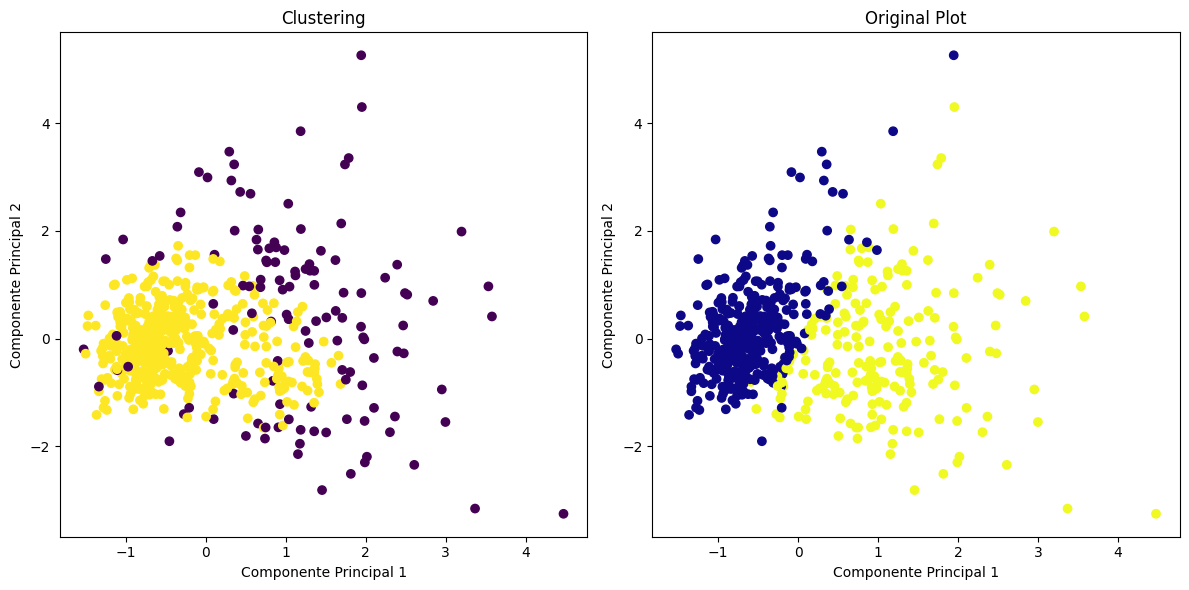

In [62]:
# Crear un objeto de figura
plt.figure(figsize=(12, 6))

# Primer subplot para el clustering
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subplot
plt.scatter(x_std_pca[:, 0], x_std_pca[:, 1], c=pred_std_dbscan, label='Clustering', cmap='viridis')
plt.title('Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Segundo subplot para el gráfico original
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo subplot
plt.scatter(x_std_pca[:, 0], x_std_pca[:, 1], c=y, label='Original Plot', cmap='plasma')
plt.title('Original Plot')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

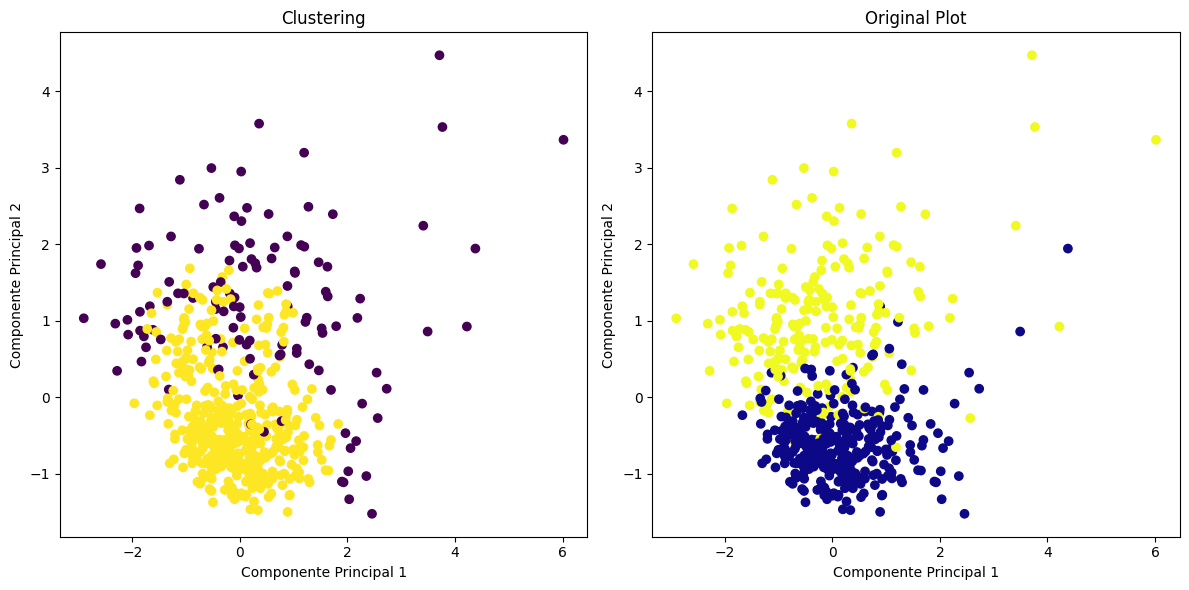

In [63]:
# Crear un objeto de figura
plt.figure(figsize=(12, 6))

# Primer subplot para el clustering
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subplot
plt.scatter(x_std_pca[:, 2], x_std_pca[:, 0], c=pred_std_dbscan, label='Clustering', cmap='viridis')
plt.title('Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Segundo subplot para el gráfico original
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo subplot
plt.scatter(x_std_pca[:, 2], x_std_pca[:, 0], c=y, label='Original Plot', cmap='plasma')
plt.title('Original Plot')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [64]:
dbscan_minmax = DBSCAN(min_samples=10,eps=0.5)
pred_minmax_dbscan  = dbscan_std.fit_predict(x_minmax_pca)
save_metrics('dbscan - minmaxScaler',x_minmax_pca,y,pred_minmax_dbscan)

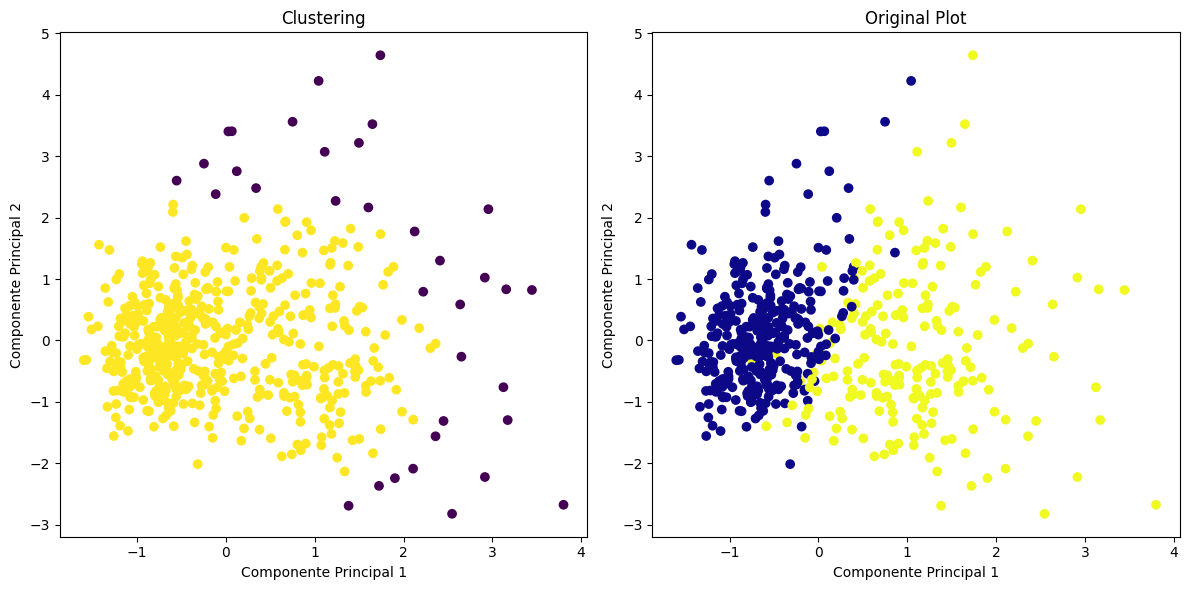

In [65]:
# Crear un objeto de figura
plt.figure(figsize=(12, 6))

# Primer subplot para el clustering
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subplot
plt.scatter(x_minmax_pca[:, 0], x_minmax_pca[:, 1], c=pred_minmax_dbscan, label='Clustering', cmap='viridis')
plt.title('Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Segundo subplot para el gráfico original
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo subplot
plt.scatter(x_minmax_pca[:, 0], x_minmax_pca[:, 1], c=y, label='Original Plot', cmap='plasma')
plt.title('Original Plot')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

### Agglomerative Clustering

In [66]:
agglo_std = AgglomerativeClustering(n_clusters=2,linkage='ward')
pred_agglo_std = agglo_std.fit_predict(x_std_pca)
save_metrics('Agglomerative Clustering - stdScaler',x_std_pca,y,pred_agglo_std)

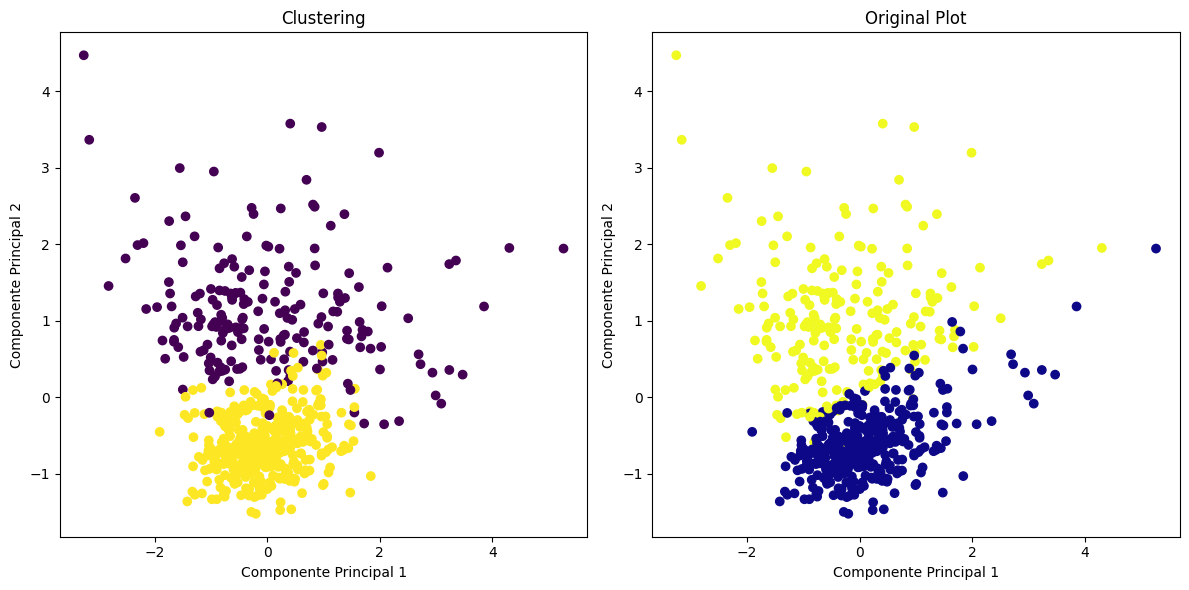

In [67]:
# Crear un objeto de figura
plt.figure(figsize=(12, 6))

# Primer subplot para el clustering
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subplot
plt.scatter(x_std_pca[:, 1], x_std_pca[:, 0], c=pred_agglo_std, label='Clustering', cmap='viridis')
plt.title('Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Segundo subplot para el gráfico original
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo subplot
plt.scatter(x_std_pca[:, 1], x_std_pca[:, 0], c=y, label='Original Plot', cmap='plasma')
plt.title('Original Plot')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

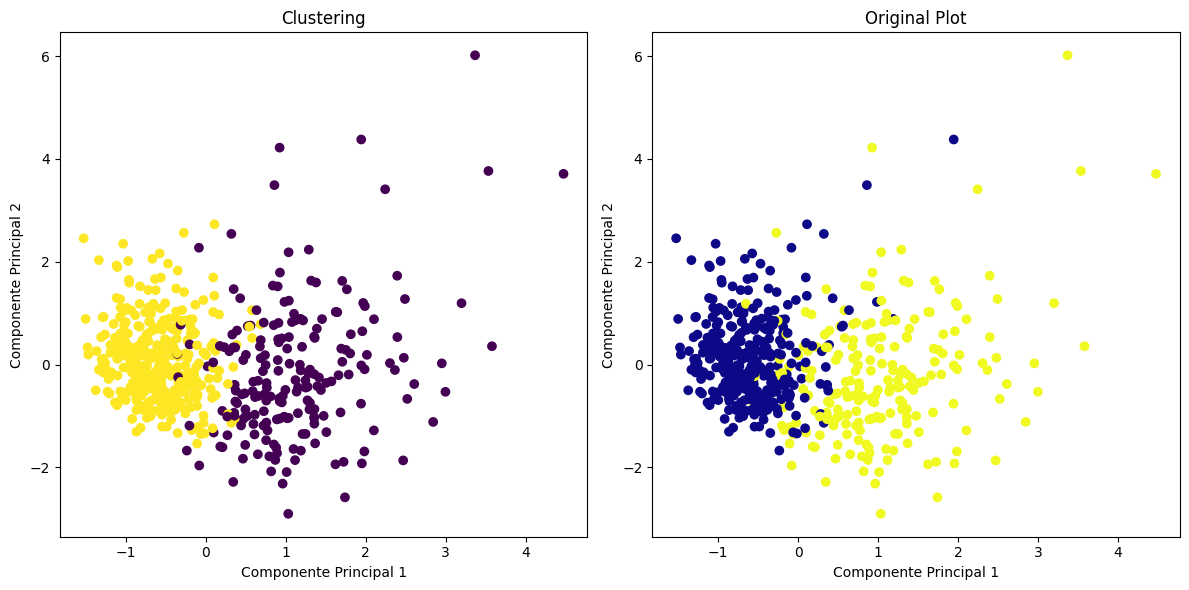

In [68]:
# Crear un objeto de figura
plt.figure(figsize=(12, 6))

# Primer subplot para el clustering
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subplot
plt.scatter(x_std_pca[:, 0], x_std_pca[:, 2], c=pred_agglo_std, label='Clustering', cmap='viridis')
plt.title('Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Segundo subplot para el gráfico original
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo subplot
plt.scatter(x_std_pca[:, 0], x_std_pca[:, 2], c=y, label='Original Plot', cmap='plasma')
plt.title('Original Plot')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [69]:
agglo_minmax = AgglomerativeClustering(n_clusters=2, linkage='ward')
pred_minmax_agglo  = agglo_minmax.fit_predict(x_minmax_pca)
save_metrics('Agglomerative Clustering - minmaxScaler',x_minmax_pca,y,pred_minmax_agglo)

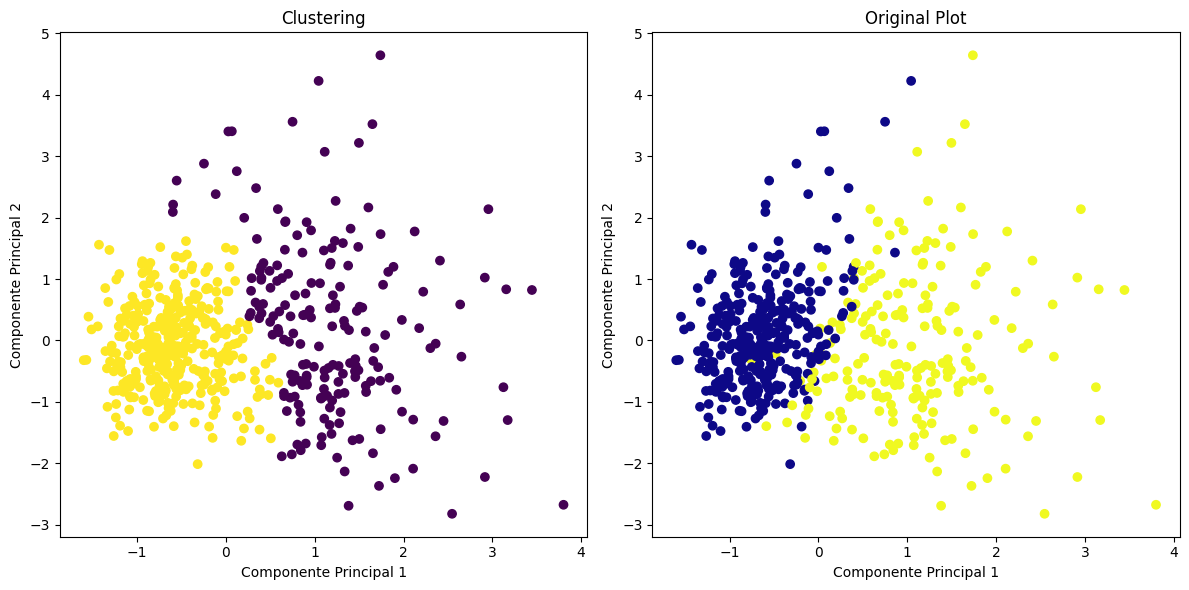

In [70]:
# Crear un objeto de figura
plt.figure(figsize=(12, 6))

# Primer subplot para el clustering
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subplot
plt.scatter(x_minmax_pca[:, 0], x_minmax_pca[:, 1], c=pred_minmax_agglo, label='Clustering', cmap='viridis')
plt.title('Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Segundo subplot para el gráfico original
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo subplot
plt.scatter(x_minmax_pca[:, 0], x_minmax_pca[:, 1], c=y, label='Original Plot', cmap='plasma')
plt.title('Original Plot')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

# Results

Visually, the ``KMeans algorithm with Standard Scaler`` shows better performance in terms of clustering. Although ``KMeans with MinMaxScaler`` obtains slightly superior metrics in several aspects (such as the silhouette coefficient and the Calinski-Harabasz index), the combination of KMeans and ``Standard Scaler`` achieves a better balance in the most relevant metrics to assess the quality of the clusters.

In particular, the ``V-Measure`` ``(0.632747)`` values ​​for ``KMeans with Standard Scaler`` are higher compared to other methods, suggesting that it better captures the structure of the data in a way that is consistent with the true labels. Furthermore, visually, the clusters appear to be better defined and separated with this combination, reinforcing its suitability for clustering in this context.

In [71]:
pd.DataFrame(metrics,columns= ['model','silhouette','davies_bouldin','adjusted_rand','v_measure','calinski'])

,model,silhouette,davies_bouldin,adjusted_rand,v_measure,calinski
0,kmeans - stdScaler,0.336634,1.498310,0.729923,0.632747,183.564487
1,kmeans - minmaxScaler,0.429053,1.108885,0.730175,0.623086,330.084213
2,dbscan - stdScaler,0.362569,2.136592,0.209411,0.144718,99.240945
3,dbscan - minmaxScaler,0.516847,1.596073,0.051218,0.041766,87.767870
4,Agglomerative Clustering - stdScaler,0.328674,1.606721,0.659706,0.535932,170.385798
5,Agglomerative Clustering - minmaxScaler,0.430828,1.152056,0.586275,0.464760,317.631785
